In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pandas as pd


# 1 - Load Fashion MNIST by Pandas, exactly the same procedure as in Logistic Regression

In [4]:
# you can download the datasets at Kaggle and change this to your fie location
TRAIN_FILE = '../fashionmnist/fashion-mnist_train.csv'
TEST_FILE = '../fashionmnist/fashion-mnist_test.csv'
train_data = pd.read_csv(TRAIN_FILE)
test_data = pd.read_csv(TEST_FILE)
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X_train_all = np.array(train_data.iloc[:, 1:])
print('pixel value max=', np.max(X_train_all))
X_train_all = X_train_all/ 255
X_train_all = X_train_all.T
m_train_all = X_train_all.shape[1]
num_px = X_train_all.shape[0]
num_class = 10
y_train_all = np.array(train_data.iloc[:, 0], dtype = 'uint8').reshape(1,-1)
print('total number of training examples =', m_train_all, ', number of pixels =', num_px)
#To speed up calculation, only 5000 out of 60000 examples will be used as training set in batch 
#Although the original data are already random, still shuffle them for general purpose
m_train = 5000
np.random.seed( 3 )
permutation = list(np.random.permutation(m_train_all))
shuffled_X = X_train_all[:,permutation]
shuffled_y = y_train_all[:,permutation]
X_train = shuffled_X[:,0:m_train]
y_train = shuffled_y[:,0:m_train]
print('X_train shape', X_train.shape, 'y_train shape', y_train.shape)
print('number of training examples used:', X_train.shape[1])
X_test = (np.array(test_data.iloc[:, 1:])/255).T
y_test = np.array(test_data.iloc[:, 0], dtype = 'uint8').reshape(1,-1)
print('X_test shape:', X_test.shape, 'y_test shape:', y_test.shape)

pixel value max= 255
total number of training examples = 60000 , number of pixels = 784
X_train shape (784, 5000) y_train shape (1, 5000)
number of training examples used: 5000
X_test shape: (784, 10000) y_test shape: (1, 10000)


# 2 - Fully Connected Neural Networks 

In [8]:
layers_dims = [X_train.shape[0], 30,20, 10]
#l=0 is always called 'init', just correspond to X
# In this problem, L = 3, l=0 just X, l=1,2 Relu, l=3 softmax
activations = ['init','Relu','Relu','softmax']

### different initializations, use fixed random seed to get same result for batch 

In [22]:
def initialize_parameters_rand(layers_dims):    
    np.random.seed(3)
    paras = {}
    L = len(layers_dims) - 1 # integer representing the number of layers

    for l in range(1, L + 1):
        paras['W' + str(l)] = (np.random.randn(layers_dims[l-1],layers_dims[l])*0.01).T
        paras['b' + str(l)] = np.zeros((layers_dims[l],1))
        
    return paras

def initialize_parameters_he(layers_dims):    
    np.random.seed(3)
    paras = {}
    L = len(layers_dims) - 1 # integer representing the number of layers

    for l in range(1, L + 1):
        paras['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt(2/layers_dims[l-1])
        paras['b' + str(l)] = np.zeros((layers_dims[l],1))
        
    return paras

### Activation functions and derivatives

In [10]:
def soft_max(Z):
    # substract Z by max(Z) to avoid numerical blowing up
    # although usually each number of Z shouldn't be too big
    Z -= np.max(Z,axis=0)
    A = np.exp(Z)
    norm_A = np.sum(A, axis = 0, keepdims = True)
    softmax = A/norm_A
    return softmax

def Relu(Z):
    res = np.maximum(0, Z)
    return res

def Relu_backward(Z):
    Z[Z>0] = 1
    Z[Z<=0] = 0
    return Z

### Forward propagation and cost functions

In [11]:
def linear_activation_forward(Wl, bl, Alminus1, activation):
    Zl = np.dot(Wl, Alminus1) + bl
    if activation == 'Relu':
        Al = Relu(Zl)
    elif activation == 'softmax':
        Al = soft_max(Zl)     
    cache = (Zl, Alminus1)
    return Al, cache

def forward_propagation(paras, X, activations):
    L = len(paras)//2
    #initialize at l=0, cache at l = 0 is never used, assigning values to keep index   
    #store (Zl, Al-1) for each l, they're going to be used in backward propagation
    caches = [(0,0)]
    #A0 = X
    Alminus1 = X
    for l in range(1,L+1):
        activation = activations[l]
        Al, cache = linear_activation_forward(paras['W'+str(l)], paras['b'+str(l)], Alminus1, activation)
        caches.append(cache)
        #update A for next step
        Alminus1 = Al
    AL = Al
    return AL, caches

def regularization(paras, lambd, m):
    L = len(paras)//2
    reg = 0
    for l in range(1,L+1):
        Wl = paras['W' + str(l)]
        reg += np.sum(Wl*Wl)
    reg *= lambd/2/m 
    return reg
                

def compute_cost_softmax_reg(AL, y, paras, lambd):
    m = y.shape[1]
    L = len(paras)//2    
    reg = regularization(paras, lambd, m)
    cost = -1/m * np.sum(np.log(AL[y, range(m)]),axis = 1)
    cost += reg
    cost = np.squeeze(cost)
    return cost

### Backward propagation and gradient descent

In [12]:
def cost_one_layer_backward(y, AL, cache, para, activation, lambd):
    WL = para
    (ZL, ALminus1) = cache
    m = y.shape[1]
    if activation == 'softmax':
        dZL = AL   
        dZL[y, range(m)] -= 1    
    
    dWL = 1/m* np.dot(dZL, ALminus1.T)
    dWL += lambd/m * WL    
    dbL = 1/m * np.sum(dZL, axis=1, keepdims = True)
     
    return dZL, dWL, dbL


def one_layer_backward(dZlplus1, cache, para, activation, lambd):
    (Wlplus1, Wl) = para
    (Zl, Alminus1) = cache
    if activation == 'Relu':
        dZl = np.dot(Wlplus1.T, dZlplus1) * Relu_backward(Zl)
        
    m = dZl.shape[1]        
    dWl = 1/m* np.dot(dZl, Alminus1.T)
    dWl += lambd/m * Wl    
    dbl = 1/m * np.sum(dZl, axis=1, keepdims = True)
     
    return dZl, dWl, dbl

def backward_propagation(y, AL, paras, caches, activations, lambd):
    L = len(paras)//2
    grads = {}
    
    for l in reversed(range(1, L+1)):
        cache = caches[l]
        activation = activations[l]
        if l ==  L:
            para = paras['W'+str(l)]
            dZl, dWl, dbl = cost_one_layer_backward(y, AL, cache, para, activation, lambd)
        else:
            para = (paras['W'+str(l+1)],paras['W'+str(l)])
            dZl, dWl, dbl = one_layer_backward(dZl, cache, para, activation, lambd)
        
        grads['dW'+str(l)] = dWl
        grads['db'+str(l)] = dbl
            
    return grads

def update_paras_with_gd(paras,grads, learning_rate):
    L = len(paras)//2
    new_paras = {}
    for l in range(1,L+1):
        Wl = paras['W'+str(l)]
        bl = paras['b'+str(l)]
        dWl = grads['dW'+str(l)]
        dbl = grads['db'+str(l)]
        Wl = Wl - learning_rate * dWl
        bl = bl - learning_rate * dbl    
        new_paras['W'+str(l)] = Wl
        new_paras['b'+str(l)] = bl
    return new_paras

### Mini-batch, cost optimization and predict function

In [15]:
def create_mini_batches(X, y, mini_batch_size):
    m = X.shape[1]
    num_complete_minibatches = m//mini_batch_size
    mini_batches = []
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:,permutation]
    shuffled_y = y[:,permutation]
    
    for i in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[:,i*mini_batch_size:(i+1)*mini_batch_size]
        mini_batch_y = shuffled_y[:,i*mini_batch_size:(i+1)*mini_batch_size]
        mini_batches.append((mini_batch_X,mini_batch_y))
    if m%mini_batch_size != 0:
        mini_batch_X = shuffled_X[:,num_complete_minibatches*mini_batch_size:m]
        mini_batch_y = shuffled_y[:,num_complete_minibatches*mini_batch_size:m]
        mini_batches.append((mini_batch_X,mini_batch_y))
    
    return mini_batches

def optimize_mini(paras, X, y, lambd, learning_rate):
    AL, caches = forward_propagation(paras, X, activations)
    cost = compute_cost_softmax_reg(AL, y, paras, lambd)
    grads = backward_propagation(y, AL, paras, caches, activations, lambd)
    paras = update_paras_with_gd(paras, grads, learning_rate)
    return cost, paras



def optimize(paras, X, y, lambd, num_iter, learning_rate):
    costs = []
    for i in range(num_iter):
        AL, caches = forward_propagation(paras, X, activations)
        cost = compute_cost_softmax_reg(AL, y, paras, lambd)
        grads = backward_propagation(y, AL, paras, caches, activations, lambd)

        paras = update_paras_with_gd(paras, grads, learning_rate)
        
        costs.append(cost)
        
        if i%(num_iter//10) == 0 :
            print('iteration=', i, cost)
    return costs, paras

def predict_accuracy(paras, X, y,activations):
    L = len(paras)//2
    #A0 = X
    Al = X
    for l in range(1,L+1):
        activation = activations[l]
        Al, _ = linear_activation_forward(paras['W'+str(l)], paras['b'+str(l)], Al, activation)

    AL = Al    
    
    predicted_class = np.argmax(AL, axis=0)
    accuracy = np.mean(predicted_class == y)
    return accuracy

### Running the batch

learning rate = 5.0E-01
iteration= 0 2.3025820324356596
iteration= 1000 2.301256041322196
iteration= 2000 1.7095556160951266
iteration= 3000 1.8788997678185173
iteration= 4000 1.4952546184785904
iteration= 5000 1.62312683855158
iteration= 6000 1.6385869654708247
iteration= 7000 1.4690345950696033
iteration= 8000 1.4861170584248182
iteration= 9000 1.6233455267847479
train accuracy: 0.335
test accuracy: 0.303
---------------------
learning rate = 1.0E-02
iteration= 0 2.3025820324356596
iteration= 1000 2.301224171481915
iteration= 2000 2.3003803394564435
iteration= 3000 2.267966571641021
iteration= 4000 1.300352821965776
iteration= 5000 1.0111719488005293
iteration= 6000 0.8875782418183077
iteration= 7000 0.7801296632681978
iteration= 8000 0.7333336886372656
iteration= 9000 0.686067507971907
train accuracy: 0.765
test accuracy: 0.748
---------------------


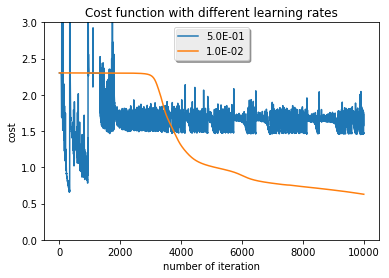

time elapsed 483.6900408267975


In [16]:
t= time.time()
learning_rates = [5*1e-1,1e-2]
lambd = 0
for rate in learning_rates:
    print('learning rate = %.1E' %rate)
    paras = initialize_parameters_rand(layers_dims)
    costs, paras = optimize(paras, X_train, y_train, lambd, num_iter = 10000, learning_rate = rate)
    plt.plot(np.squeeze(costs), label = '%.1E' %rate)
    
    
    accuracy = predict_accuracy(paras, X_train, y_train,activations)
    print('train accuracy: %.3f' %accuracy)
    accuracy = predict_accuracy(paras, X_test, y_test,activations)
    print('test accuracy: %.3f' %accuracy)
    print('---------------------')

plt.ylabel('cost')
plt.xlabel('number of iteration')
plt.title("Cost function with different learning rates" )
legend = plt.legend(loc='upper center', shadow=True)
axes = plt.gca()
axes.set_ylim([0,3])
plt.show()

t= time.time() -t
print('time elapsed', t)

Learning rate = 0.01 is the optimal learning rate for training sample size = 5000 with batch gradient descent and random initialization.
After 10,000 iterations, it achieves 74.8% test accuracy with hidden layers 30 and 20. Since the hidden layers unit and number of iteration are both small and we don't use all the training examples, we have poor test accuracy.

### Running the batch with He initialization

learning rate = 1.0E-02
iteration= 0 2.379683305655539
iteration= 1000 0.5576829480481441
iteration= 2000 0.4579243808213617
iteration= 3000 0.4040761995169302
iteration= 4000 0.3650482038853537
iteration= 5000 0.3339788622470677
iteration= 6000 0.31511850800846236
iteration= 7000 0.29363877850294556
iteration= 8000 0.27428560145666364
iteration= 9000 0.2552862076462797
train accuracy: 0.923
test accuracy: 0.834
---------------------


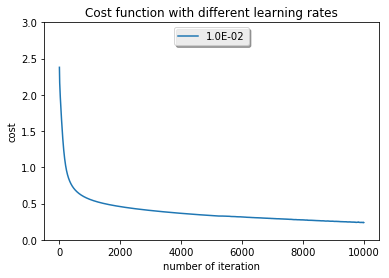

time elapsed 265.27487421035767


In [23]:
t= time.time()
learning_rates = [1e-2]
lambd = 0
for rate in learning_rates:
    print('learning rate = %.1E' %rate)
    paras = initialize_parameters_he(layers_dims)
    costs, paras = optimize(paras, X_train, y_train, lambd, num_iter = 10000, learning_rate = rate)
    plt.plot(np.squeeze(costs), label = '%.1E' %rate)
    
    
    accuracy = predict_accuracy(paras, X_train, y_train,activations)
    print('train accuracy: %.3f' %accuracy)
    accuracy = predict_accuracy(paras, X_test, y_test,activations)
    print('test accuracy: %.3f' %accuracy)
    print('---------------------')

plt.ylabel('cost')
plt.xlabel('number of iteration')
plt.title("Cost function with different learning rates" )
legend = plt.legend(loc='upper center', shadow=True)
axes = plt.gca()
axes.set_ylim([0,3])
plt.show()

t= time.time() -t
print('time elapsed', t)

Initilization is important! After 10,000 iterations, it achieves 83.4% test accuracy with hidden layers 30 and 20 with He initilization!  Since the hidden layers unit and number of iteration are both small and we don't use all the training examples, we still have poor test accuracy.

### Running the mini-batch, use all the training examples

learning rate = 5.0E-03
epoch= 0 2.3025695800512165
epoch= 50 0.7703104740324735
epoch= 100 0.4518911452190204
epoch= 150 0.5465617107708084
epoch= 200 0.36046862257168344
epoch= 250 0.37087577811438033
epoch= 300 0.3018596780808903
epoch= 350 0.2728634711027568
epoch= 400 0.24284657645473914
epoch= 450 0.3102258488902167
test accuracy: 0.875
---------------------


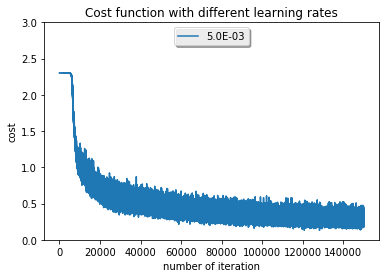

time elapsed 1139.6783740520477


In [20]:
t= time.time()
learning_rates = [5*1e-3]
lambd = 0
num_epoch = 500
for rate in learning_rates:
    print('learning rate = %.1E' %rate)
    costs = []
    paras = initialize_parameters_rand(layers_dims)
    for i in range(num_epoch):
        mini_batches = create_mini_batches(X_train_all, y_train_all, mini_batch_size=200)   
        for mini_batch in mini_batches:
            (X_mini_batch, y_mini_batch) = mini_batch    
            cost, paras = optimize_mini(paras, X_mini_batch, y_mini_batch, lambd, learning_rate = rate)
            costs.append(cost)
        if i%(num_epoch//10) == 0 :
            print('epoch=', i, cost)
            
    plt.plot(np.squeeze(costs), label = '%.1E' %rate)
    accuracy = predict_accuracy(paras, X_test, y_test,activations)
    print('test accuracy: %.3f' %accuracy)
    print('---------------------')

plt.ylabel('cost')
plt.xlabel('number of iteration')
plt.title("Cost function with different learning rates" )
legend = plt.legend(loc='upper center', shadow=True)
axes = plt.gca()
axes.set_ylim([0,3])
plt.show()

t= time.time() -t
print('time elapsed', t)


It achieves 87.5% test accuaracy with random initialization and mini-batch! We can clearly see oscillatory behavior due to the mini-batch gradient descent method. If we use Adam optimizor the curve will drop faster and smoother.

learning rate = 5.0E-03
epoch= 0 1.2036675288089764
epoch= 25 0.44011523988571216
epoch= 50 0.3779756851558297
epoch= 75 0.3839833562659385
epoch= 100 0.3014332293872252
epoch= 125 0.4518704290686937
epoch= 150 0.35901344580821387
epoch= 175 0.2858639643356746
epoch= 200 0.3060157219314626
epoch= 225 0.3735509218166291
test accuracy: 0.873
---------------------


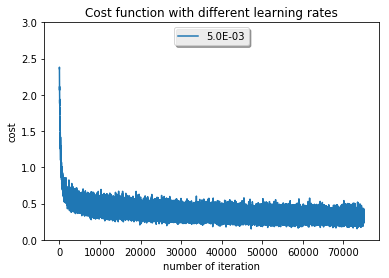

time elapsed 547.2945427894592


In [24]:
#He initilization
t= time.time()
learning_rates = [5*1e-3]
lambd = 0
num_epoch = 250
for rate in learning_rates:
    print('learning rate = %.1E' %rate)
    costs = []
    paras = initialize_parameters_he(layers_dims)
    for i in range(num_epoch):
        mini_batches = create_mini_batches(X_train_all, y_train_all, mini_batch_size=200)   
        for mini_batch in mini_batches:
            (X_mini_batch, y_mini_batch) = mini_batch    
            cost, paras = optimize_mini(paras, X_mini_batch, y_mini_batch, lambd, learning_rate = rate)
            costs.append(cost)
        if i%(num_epoch//10) == 0 :
            print('epoch=', i, cost)
            
    plt.plot(np.squeeze(costs), label = '%.1E' %rate)
    accuracy = predict_accuracy(paras, X_test, y_test,activations)
    print('test accuracy: %.3f' %accuracy)
    print('---------------------')

plt.ylabel('cost')
plt.xlabel('number of iteration')
plt.title("Cost function with different learning rates" )
legend = plt.legend(loc='upper center', shadow=True)
axes = plt.gca()
axes.set_ylim([0,3])
plt.show()

t= time.time() -t
print('time elapsed', t)

Initilization is important! Here we downsize the total number of epoch to 250 comparing to random initialization, it achieves 87.3% test accuracy with hidden layers 30 and 20 with He initilization and mini-batch! The total number of epoch can probably even be smaller. One can further improve the accuracy by increasing the hidden layers unit and use Adam.